# Sink-source connectivity for analyzing cognitive state

Applying the sink-source connectivity biomarker for analyzing neural correlates of behavior

# Imports

In [5]:
import h5py 
import mat73
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import mne
import re

# Load Data

In [6]:
subs = ['13']
file_paths = {}

for sub in subs:
    # create a dictionary holding the file paths
    ncsl_share = '/mnt/ncsl_share'
    file_paths[sub] = {
        'setup_path': ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT{sub}/EFRI{sub}_WAR_SES1_Setup.mat',
        'raw_path': ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT{sub}/EFRI{sub}_WAR_SES1_Raw.mat',
        # 'data_path': ncsl_share + f'/Daniel/Data/Trial_by_Chan_by_Freq_by_Time_Snapshots/Subject{sub}_snapshot_normalized.npy', # movement onset as event
        # 'data_path' : ncsl_share + f'/Daniel/Data/Trial_by_Chan_by_Freq_by_Time_Snapshots/show-card_pre-2sec_post-4sec/Subject{sub}_snapshot_normalized.npy', # visual cue as event
    }

In [7]:
raw_file = h5py.File(file_paths[subs[0]]['raw_path'])
setup_data = mat73.loadmat(file_paths[subs[0]]['setup_path'])

OSError: [Errno 112] Unable to open file (unable to open file: name = '/mnt/ncsl_share/Public/EFRI/1_formatted/SUBJECT13/EFRI13_WAR_SES1_Raw.mat', errno = 112, error message = 'Host is down', flags = 0, o_flags = 0)

# Average Time Between Events

In [ ]:
event_words = {"fixation": 30,
               "show card": 31,
               "show bet": 32,
               "start move": 35,
               "show card results": 51}

In [71]:
good_trials = setup_data['filters']['trial'][setup_data['filters']['success']].astype(int)-1
time_lengths = []
events = list(event_words.keys())

for trial in good_trials:
    time_btwn_events = []

    for i in range(len(events)-1):
        time_0 = setup_data['trial_times'][trial][0][setup_data['trial_words'][trial][0]==event_words[events[i]]][0]
        time_1 = setup_data['trial_times'][trial][0][setup_data['trial_words'][trial][0]==event_words[events[i+1]]][0]

        time_btwn_events.append(time_1 - time_0)

    time_lengths.append(time_btwn_events)

    # time_0 = setup_data['trial_times'][trial][0][setup_data['trial_words'][trial][0]==9][0]
    # time_1 = setup_data['trial_times'][trial][0][setup_data['trial_words'][trial][0]==18][0]

    # time_lengths.append(time_1 - time_0)

time_lengths = np.array(time_lengths)

In [72]:
time_lengths.mean(0)

array([1.24570349, 2.01667151, 1.09713953, 1.45859884])

# Apply Sink Source Connectivity

## Avg SI Across All Trials From Start to End of Trial

Setting up band-pass filter from 0.5 - 2e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 200.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter from 59 - 61 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 59.35, 60.65 Hz: -6.02, -6.02 dB

Setting up band-stop filter from 1.2e+02 - 1.2e+02 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 119.20, 120.80 Hz: -6.02, -6.02 dB

Setting up band-stop filter from 1.8e+02 - 1.8e+02 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-ca

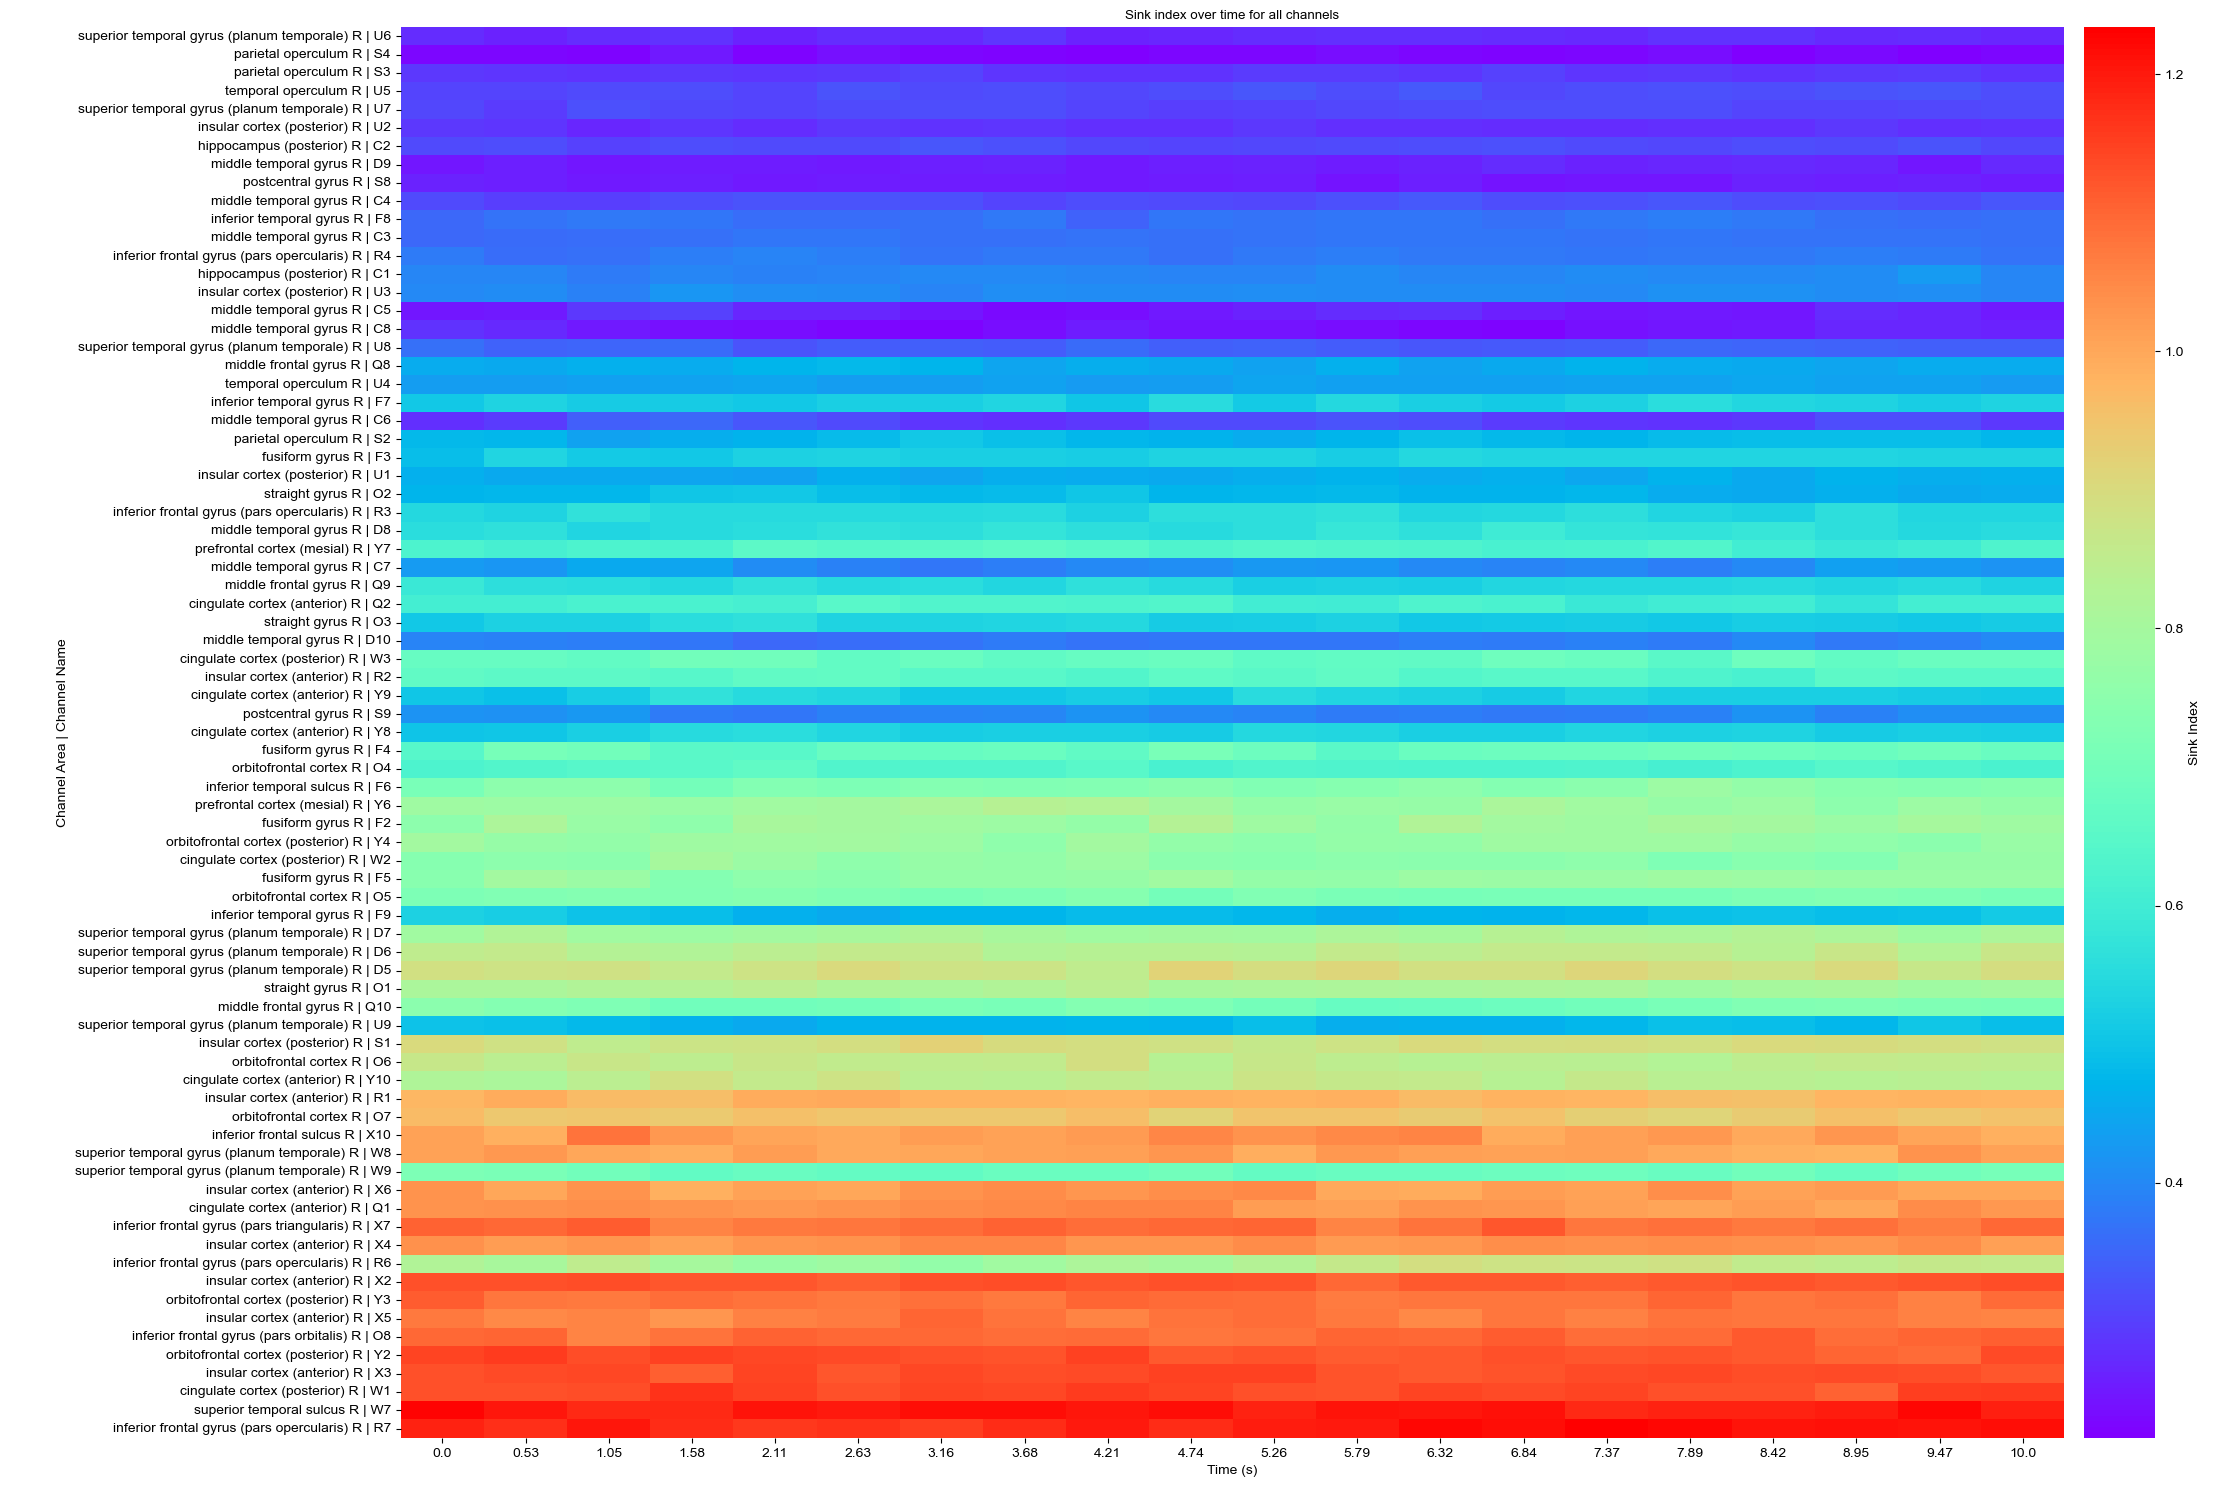

In [5]:
from sink_source import SinkSource

ss = SinkSource(raw_file, setup_data)
snapshot = ss.get_data(raw_file, 9, [0, 10])
A_hat_all_trials = ss.estimateA_all_trials(snapshot)
_, SI_wins_all_trials, _, _ = ss.computeSS(A_hat_all_trials)

dsFs = 500
window_length = snapshot.shape[2]/dsFs
num_timesteps = A_hat_all_trials.shape[3]
onset_delay = 0
time = np.linspace(0,window_length,num_timesteps) + onset_delay
time = [round(i, 2) for i in time]
fs = 500
winSize_sec = 0.5

winSize = winSize_sec*fs

ss.plot_SI_heatmap(A_hat_all_trials, SI_wins_all_trials.mean(0), winSize, fs, time)

## Avg SI Between Events

In [8]:
from sink_source import SinkSource

def plot_SI_heatmaps(raw_file, setup_data, event_word, time_window):
    ss = SinkSource(raw_file=raw_file, setup_data=setup_data)

    snapshot = ss.get_data(raw_file, event_word, time_window)

    A_hat_all_trials = ss.estimateA_all_trials(snapshot)
    A_win_all_trials, SI_wins_all_trials, _, _ = ss.computeSS(A_hat_all_trials)

    dsFs = 500
    window_length = snapshot.shape[2]/dsFs
    num_timesteps = A_hat_all_trials.shape[3]
    onset_delay = time_window[0]
    time = np.linspace(0,window_length,num_timesteps) + onset_delay
    time = [round(i, 2) for i in time]
    fs = 500
    winSize_sec = 0.5

    winSize = winSize_sec*fs

    ss.plot_SI_heatmap(A_hat_all_trials, SI_wins_all_trials.mean(0), winSize, fs, time, output_path=f'Heatmaps/Subject{sub}_{event_word}')

Setting up band-pass filter from 0.5 - 2e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 200.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter from 59 - 61 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 59.35, 60.65 Hz: -6.02, -6.02 dB

Setting up band-stop filter from 1.2e+02 - 1.2e+02 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 119.20, 120.80 Hz: -6.02, -6.02 dB

Setting up band-stop filter from 1.8e+02 - 1.8e+02 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-ca

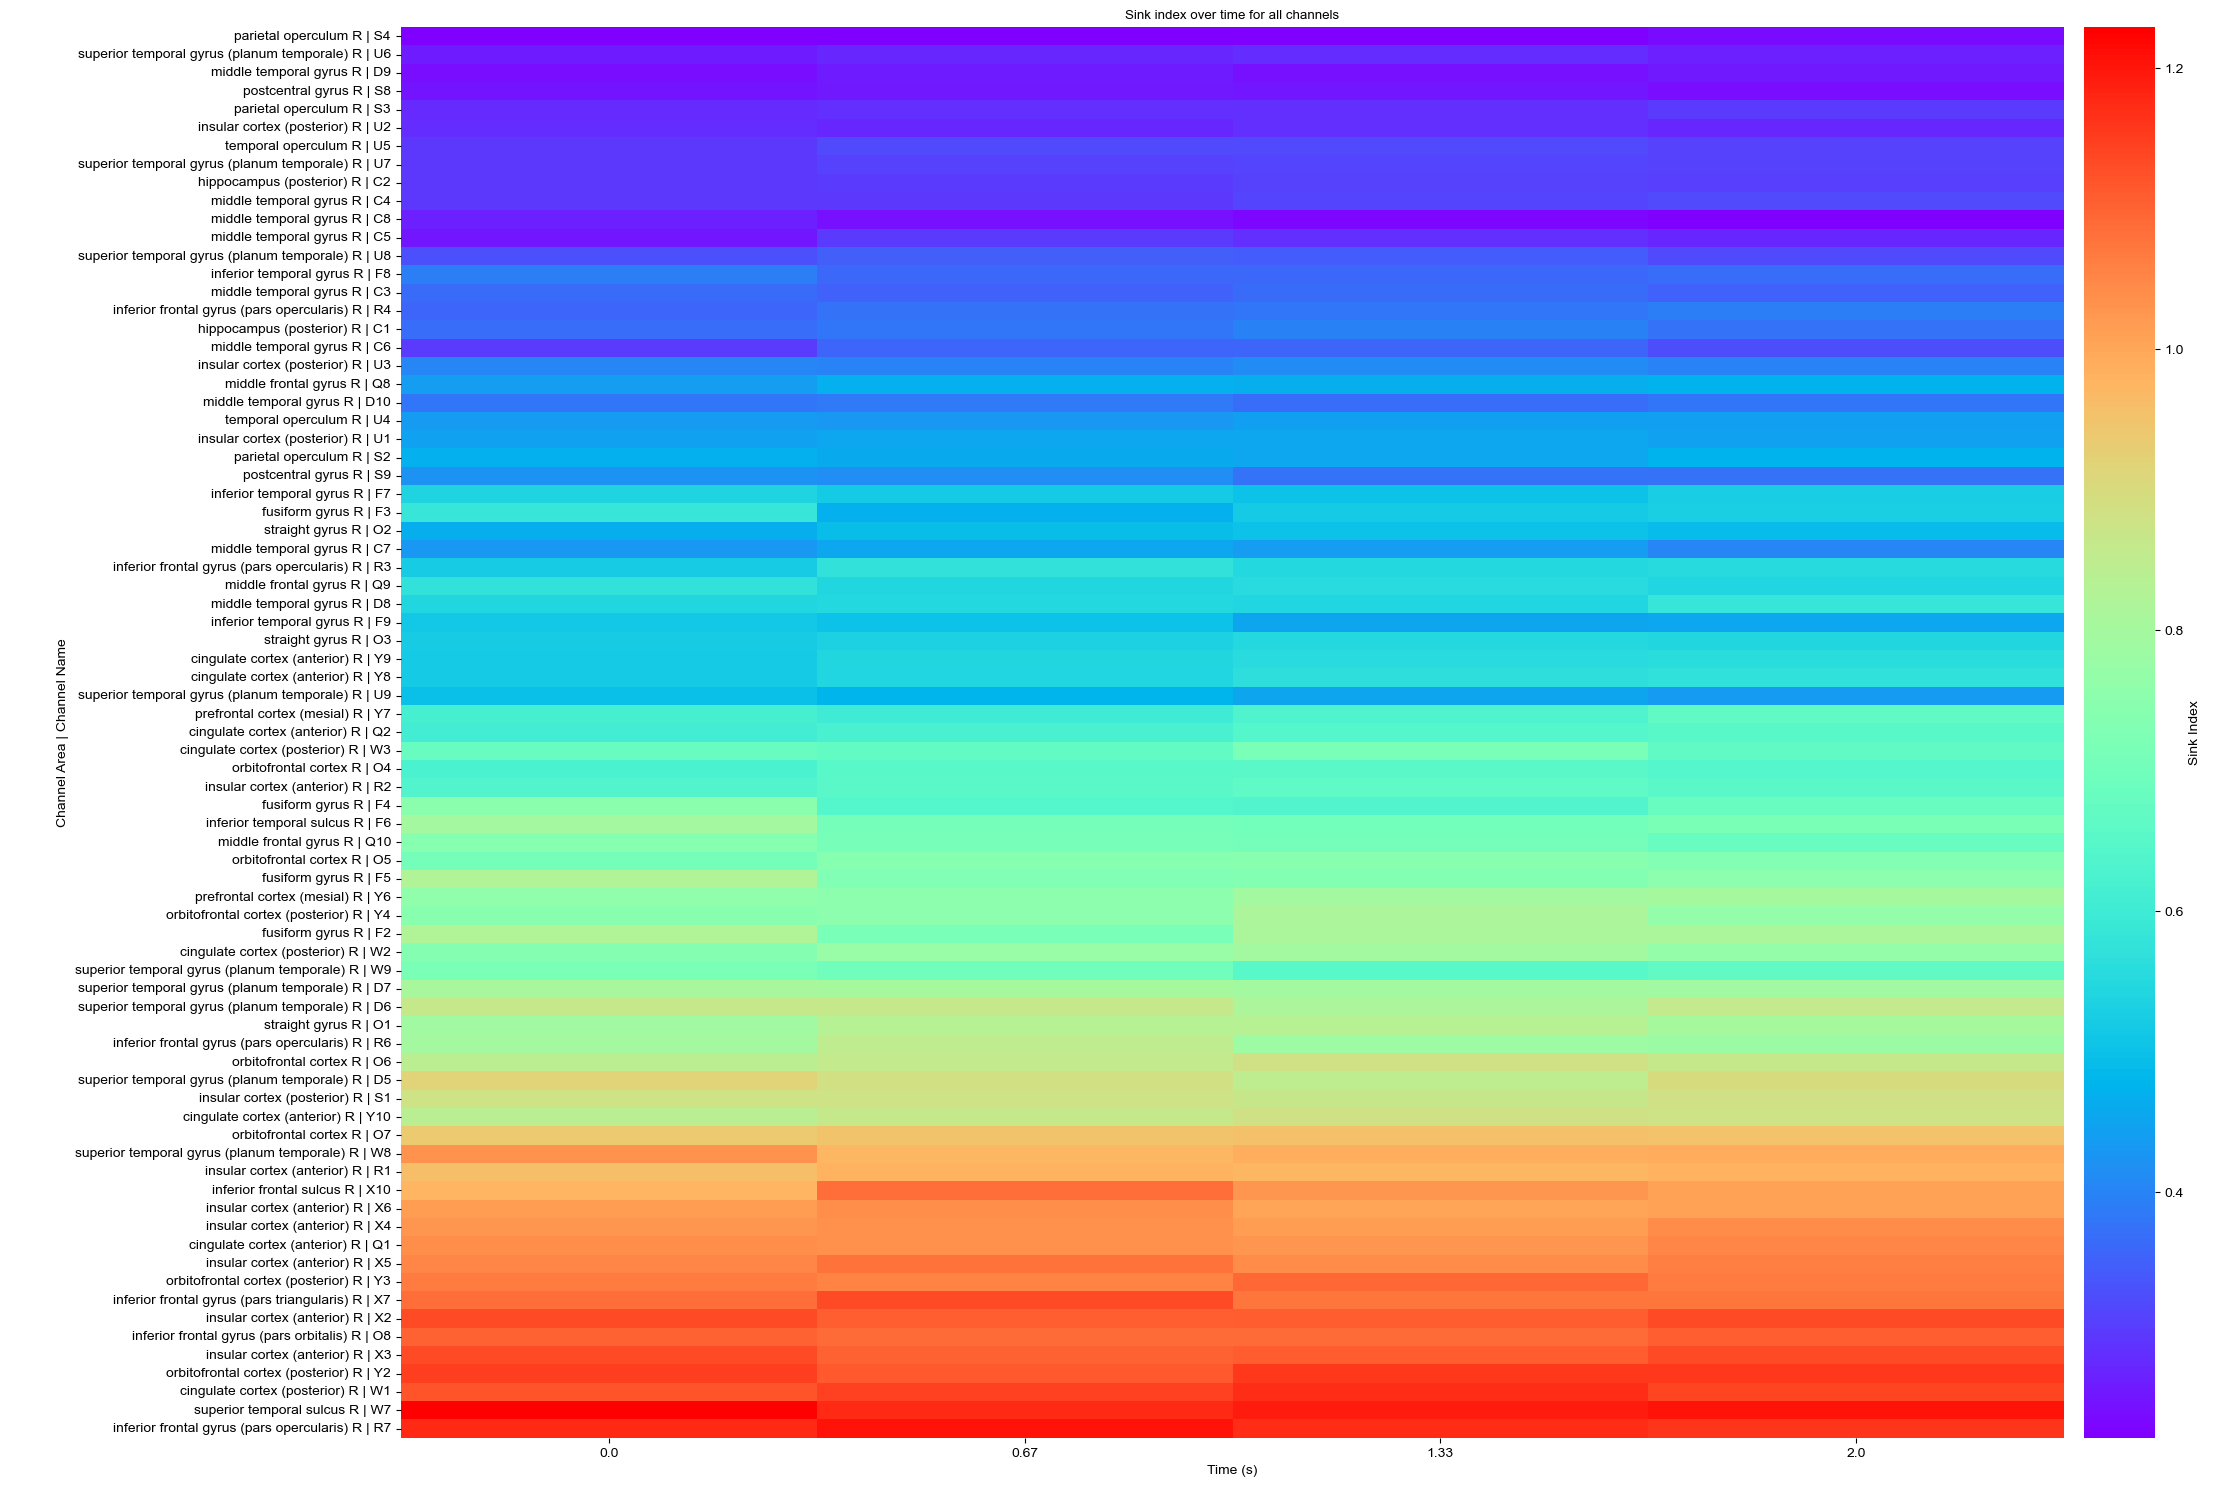

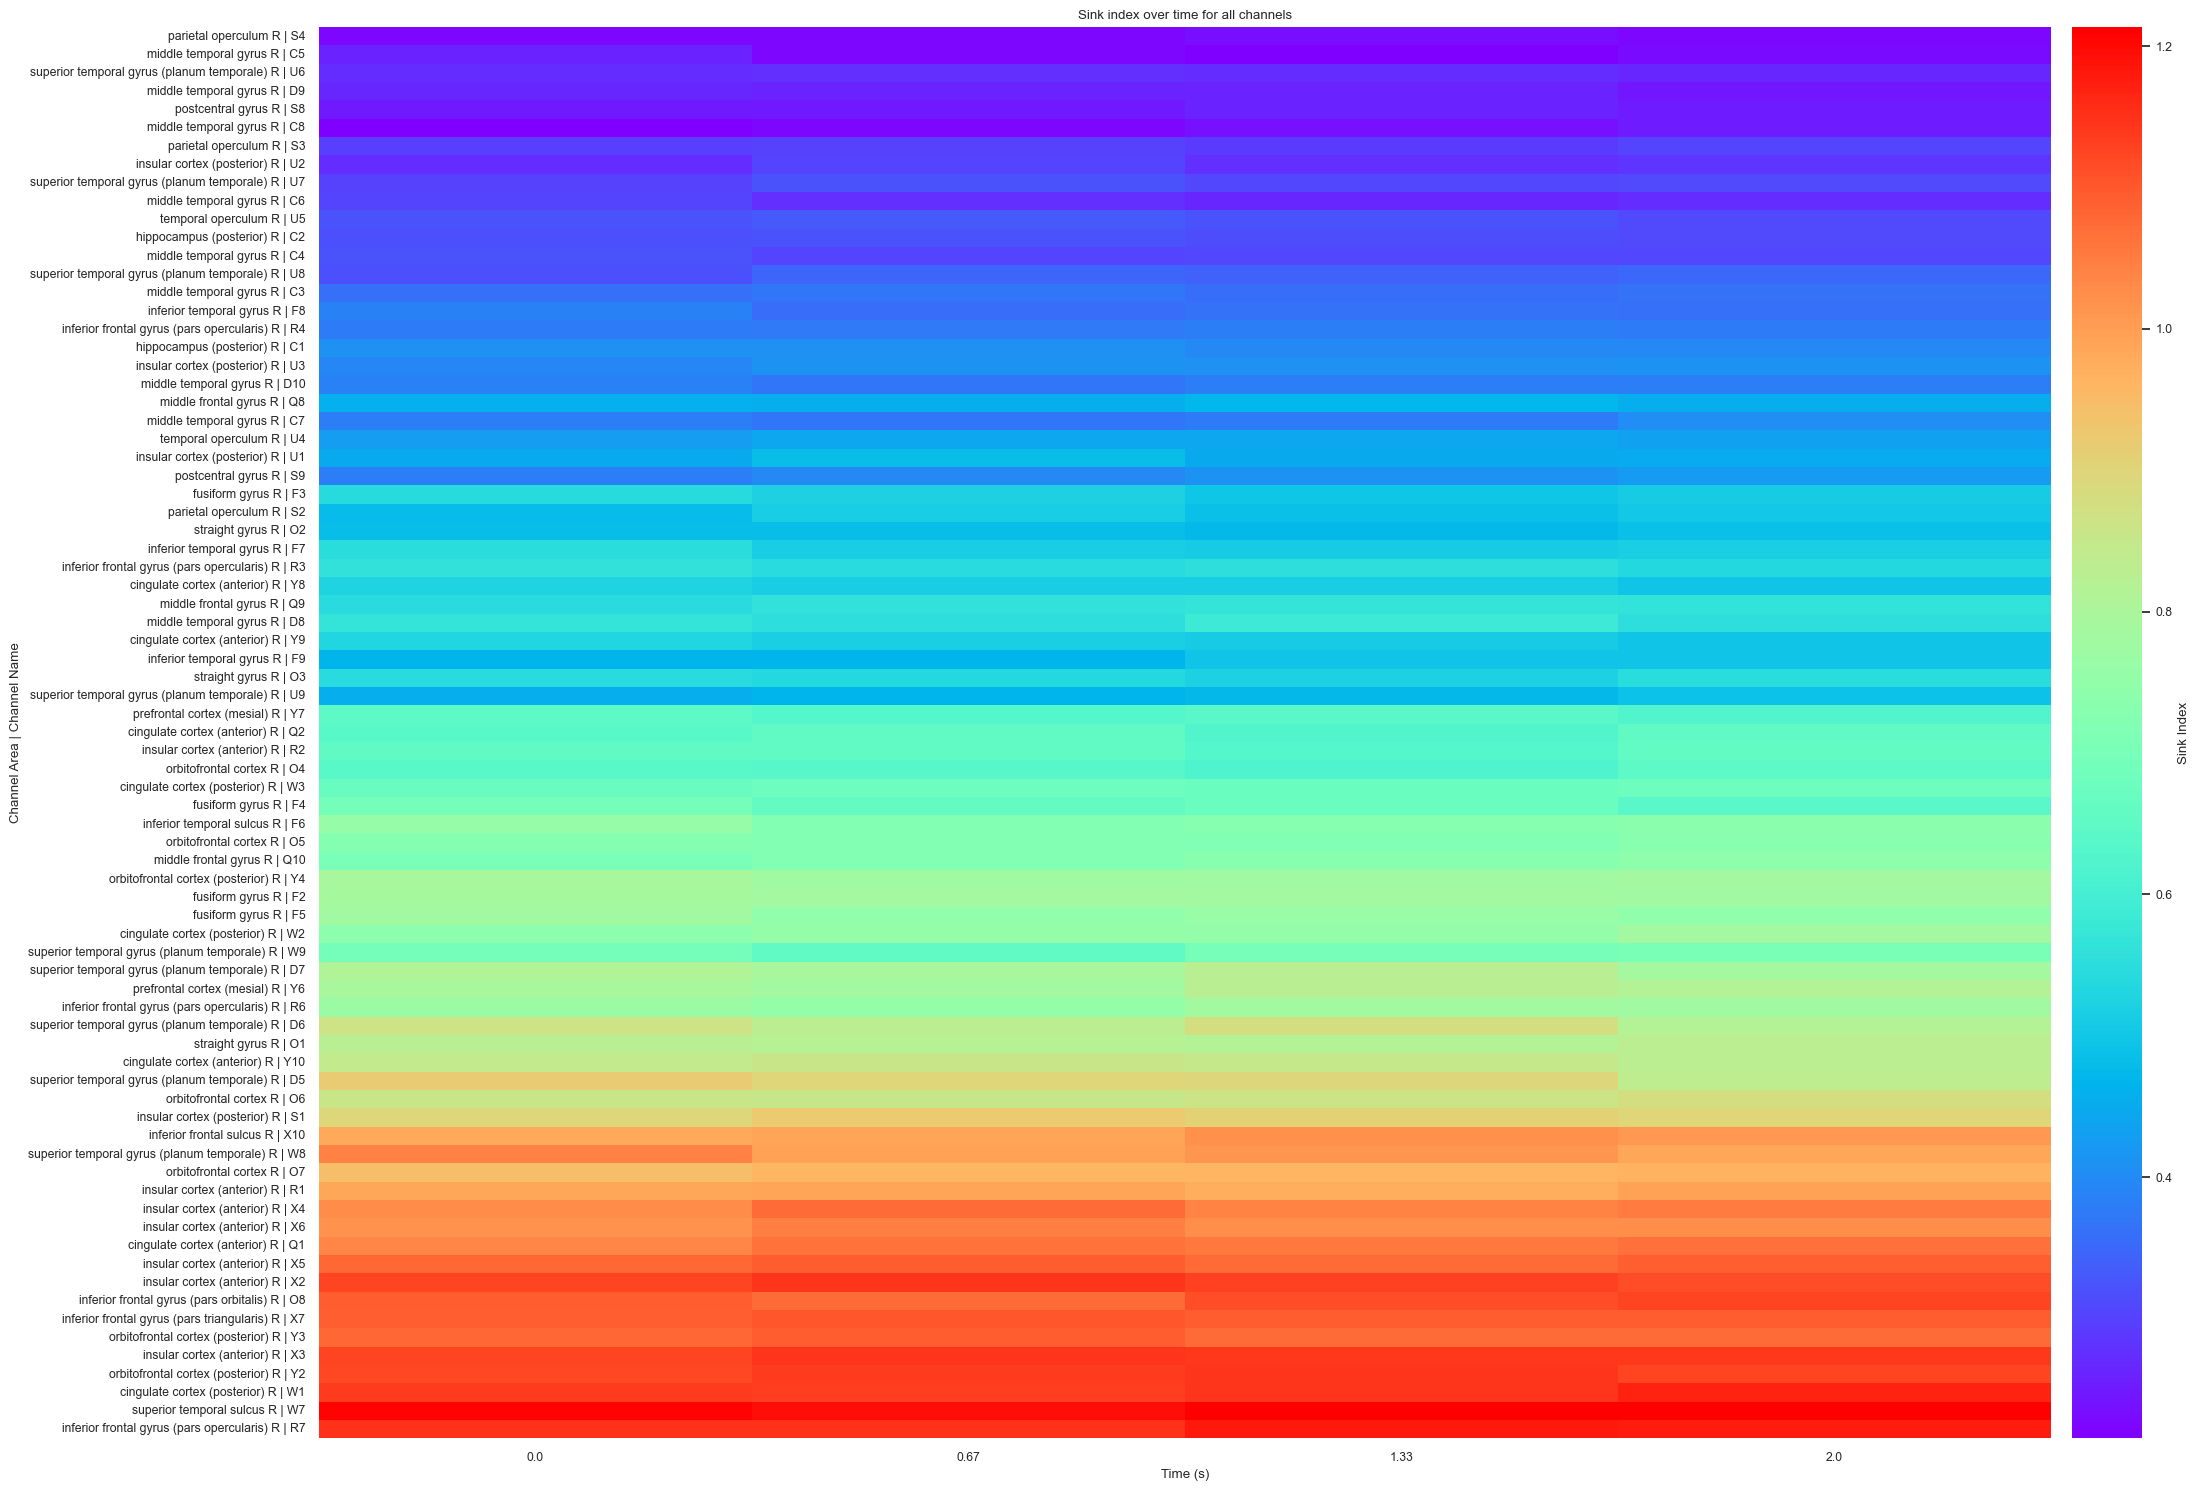

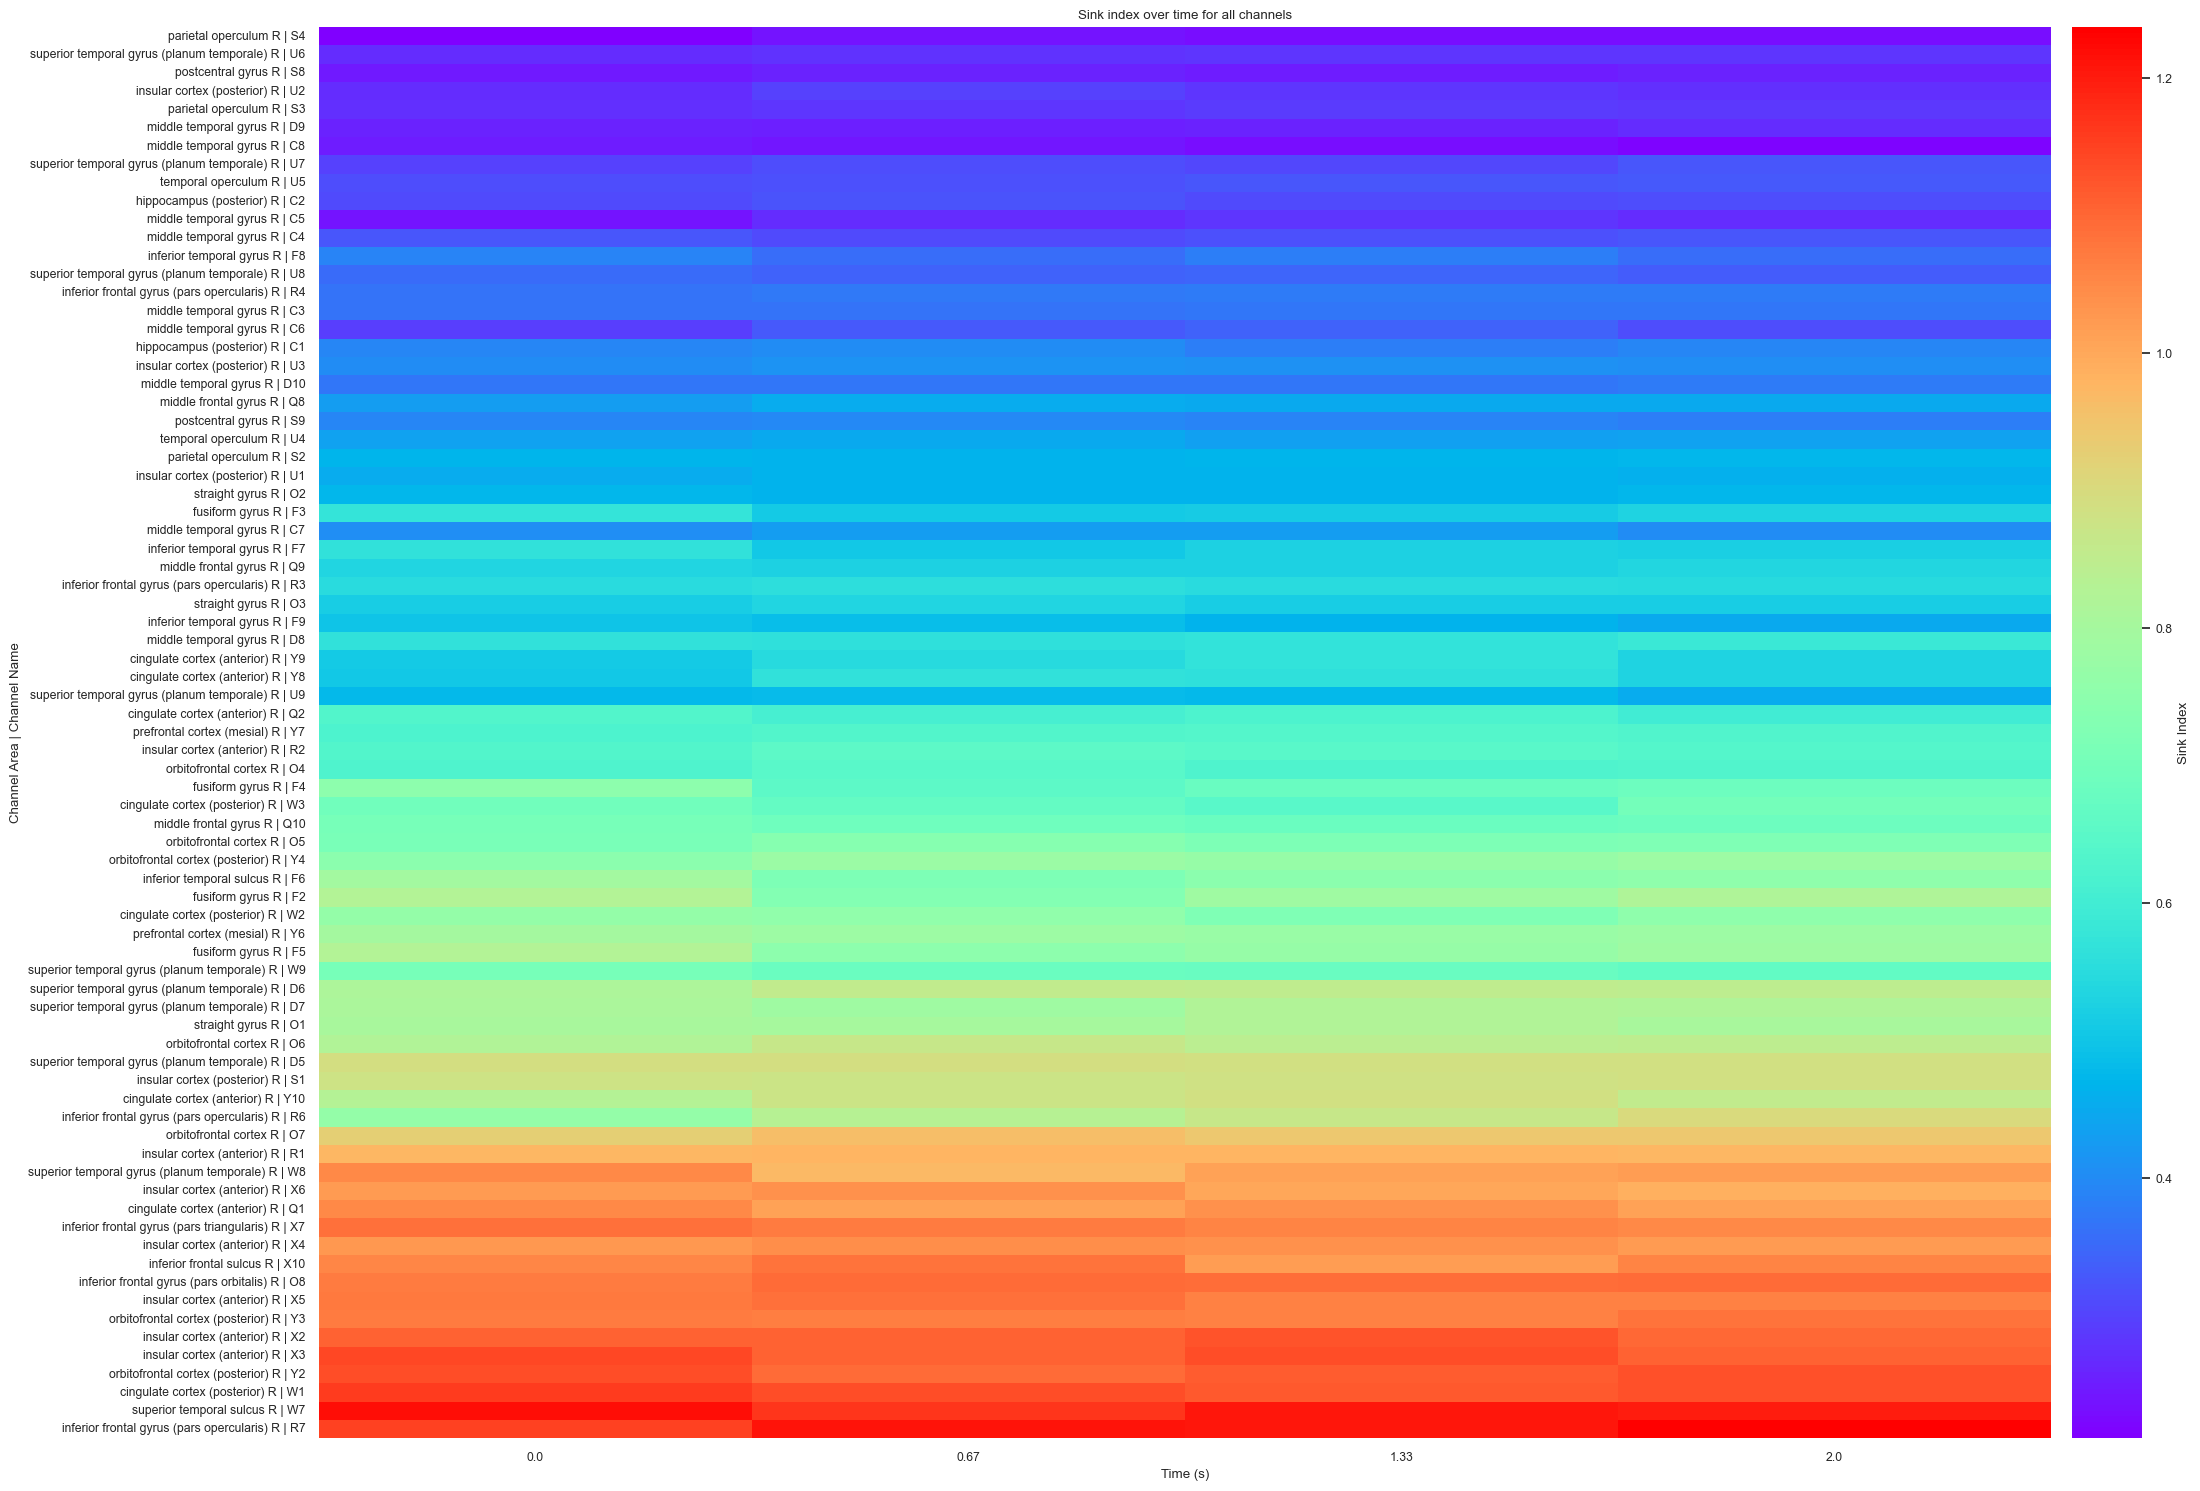

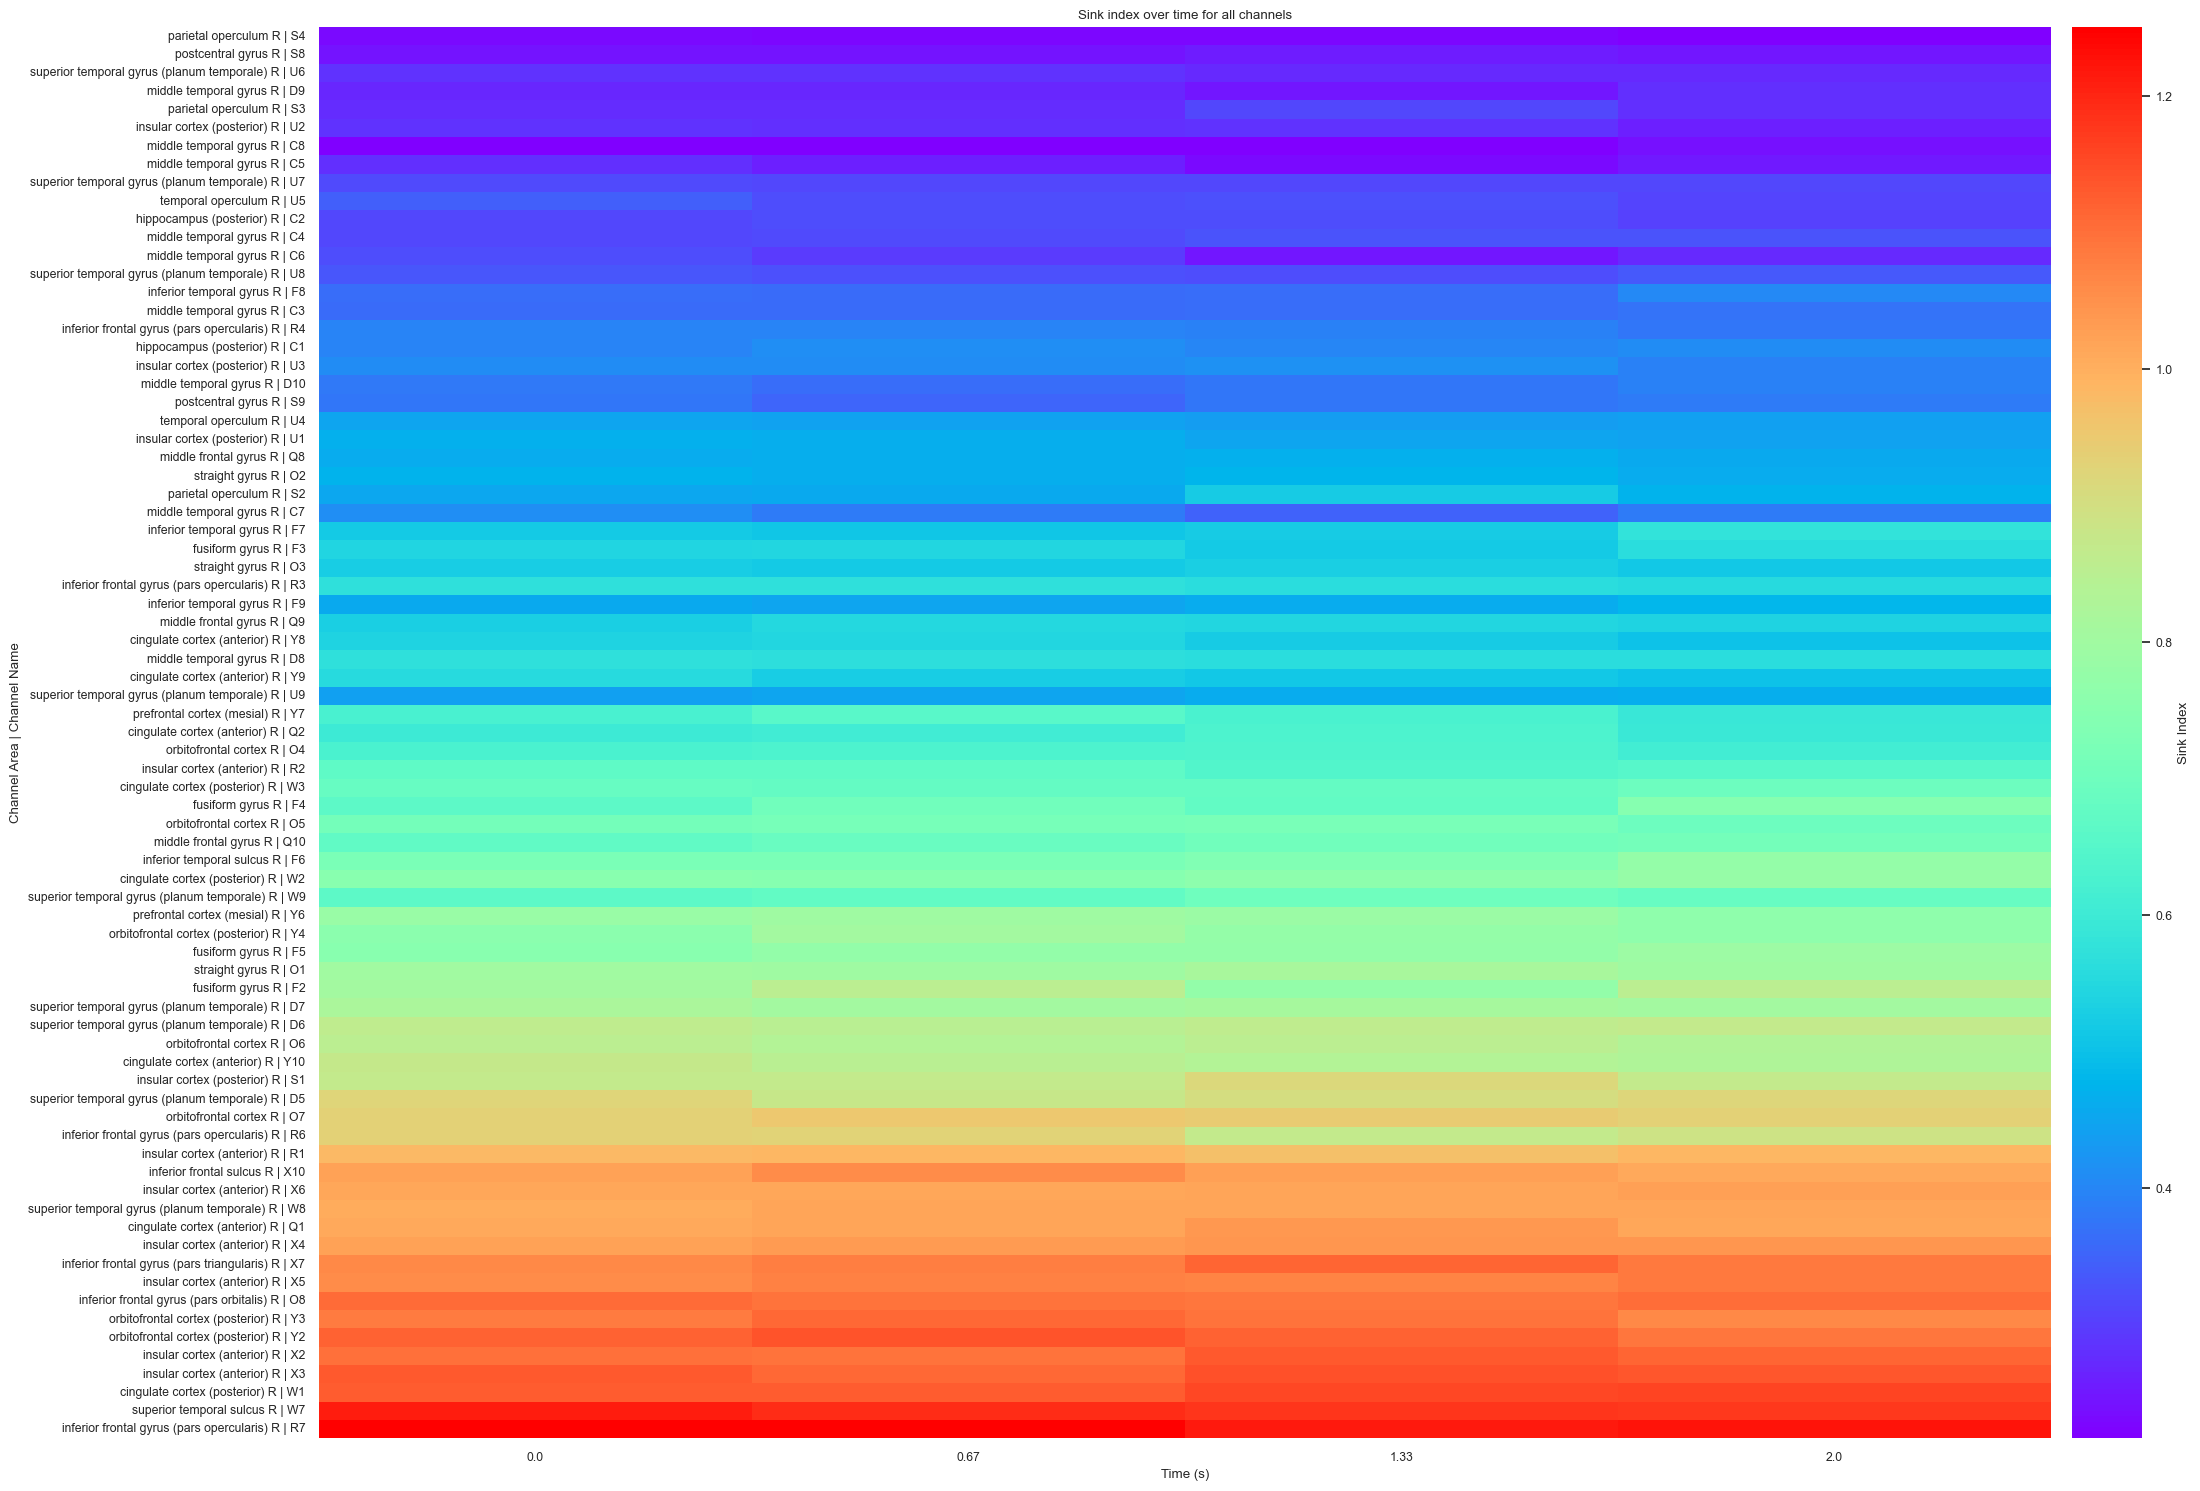

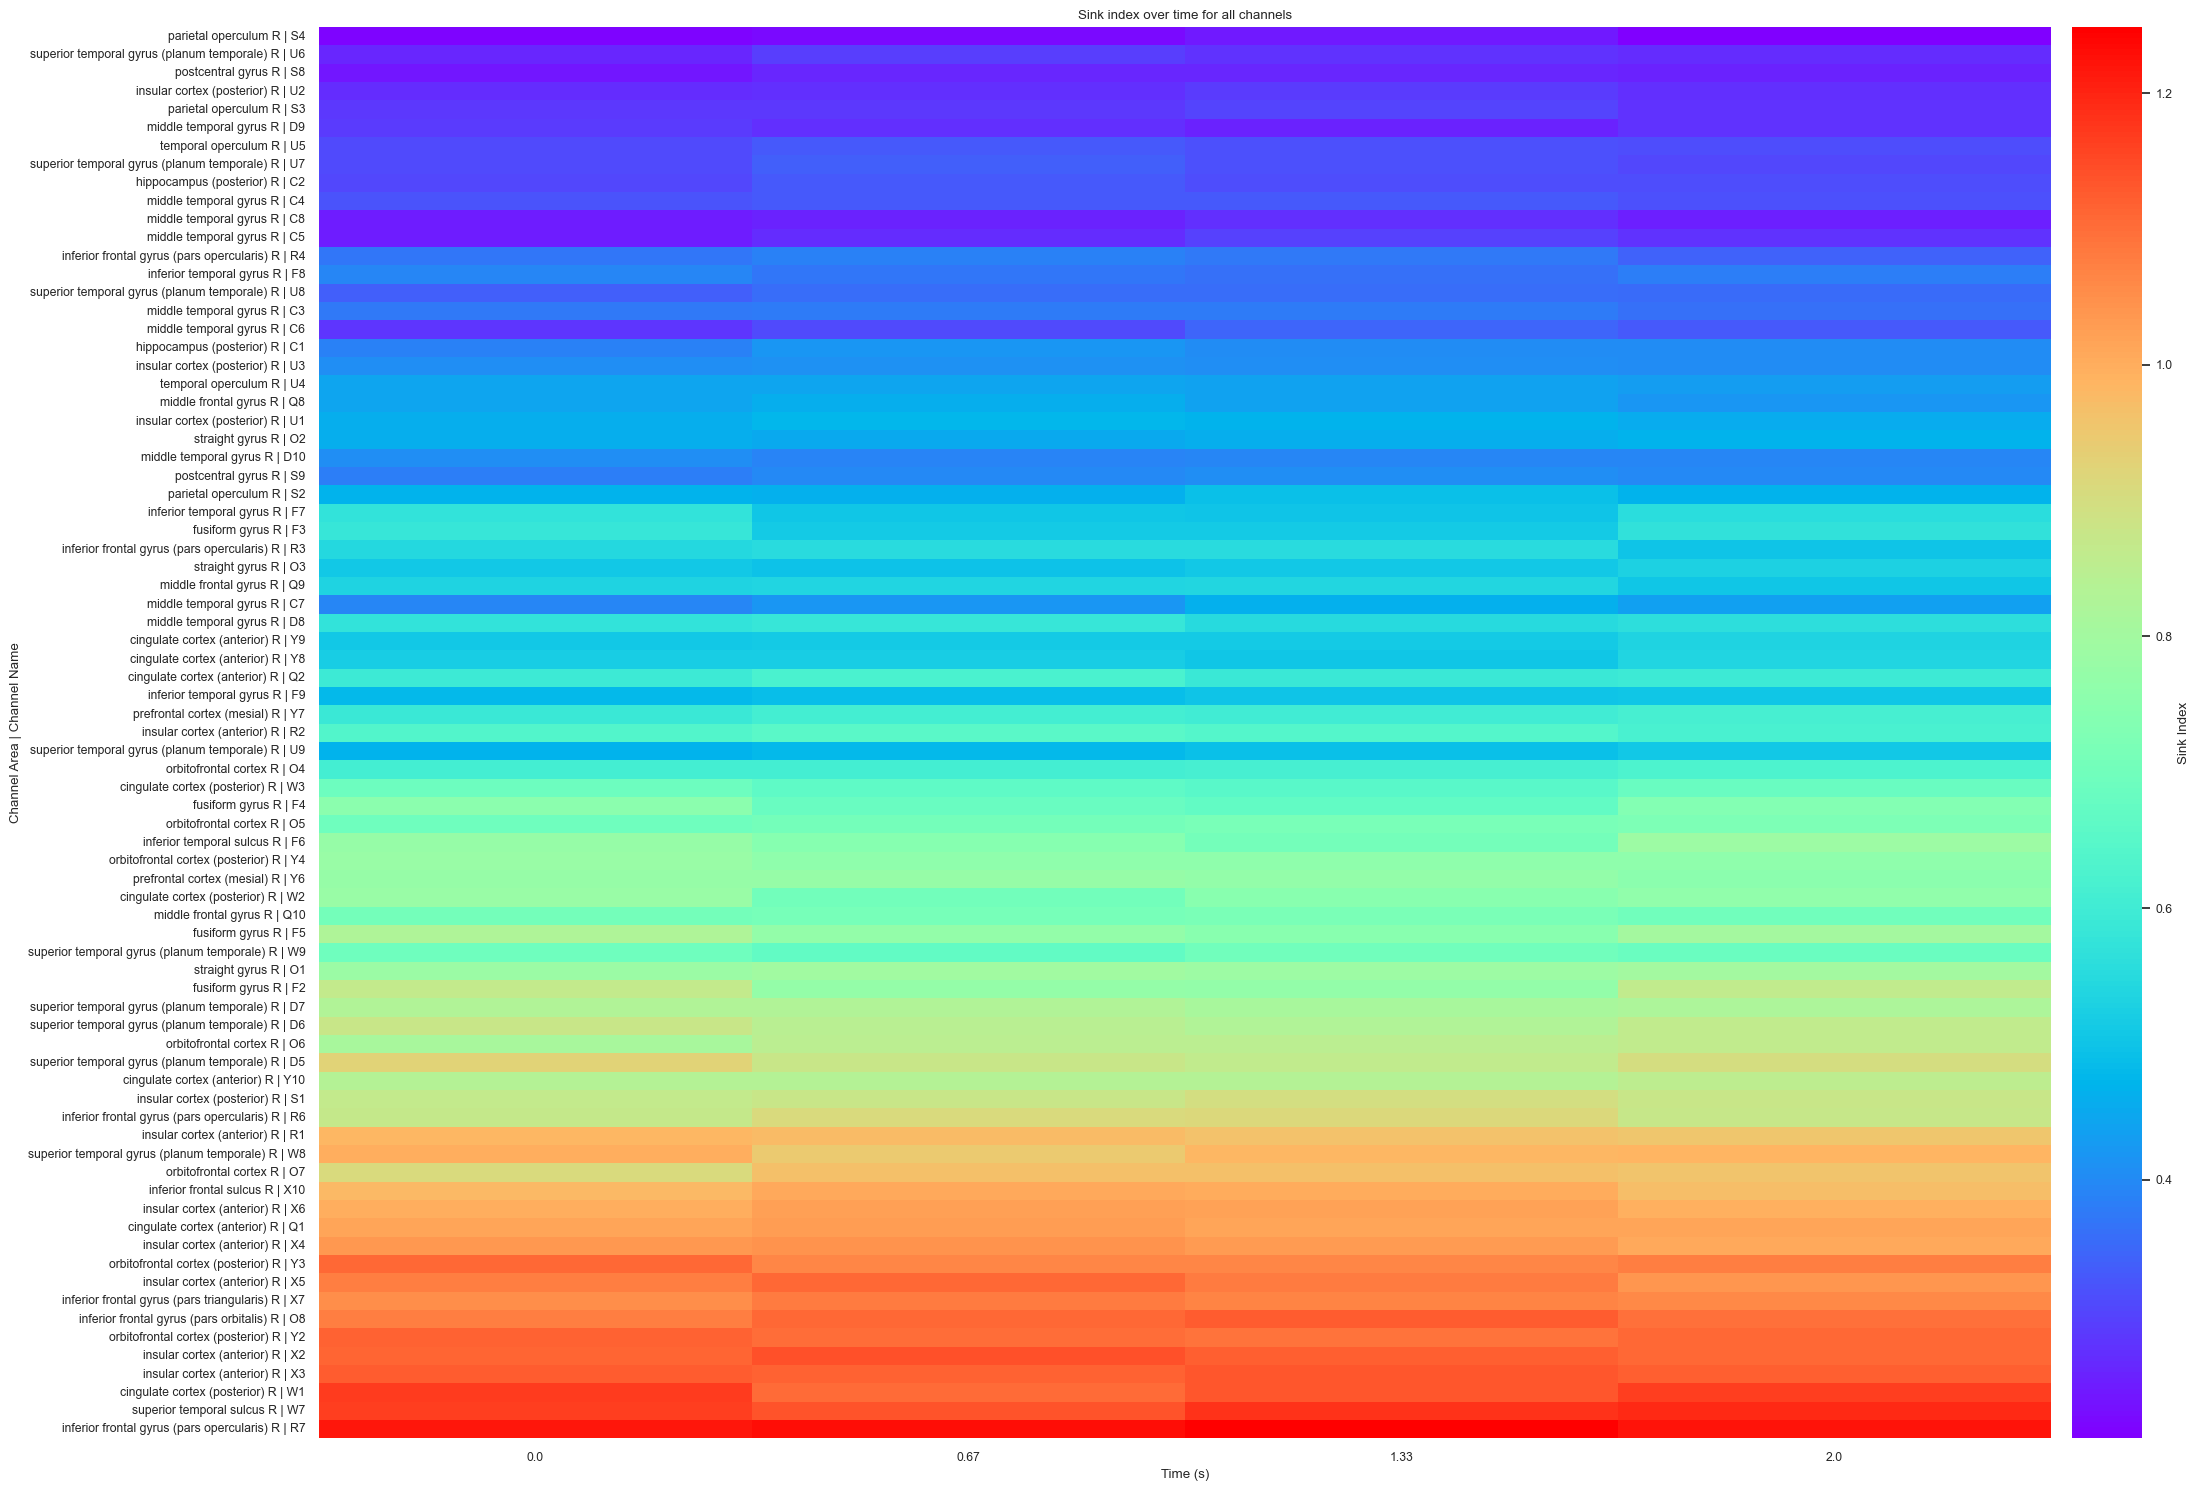

In [9]:
for event in event_words:
    plot_SI_heatmaps(raw_file, setup_data, event_words[event], [0, 2])

# Avg SI per Cognitive State

In [1]:
from sink_source import SinkSource

A_hat_cog_state = []

for event in event_words:

    ss = SinkSource(raw_file=raw_file, setup_data=setup_data)

    snapshot = ss.get_data(raw_file, event_words[event], [0,2])

    A_hat_all_trials = ss.estimateA_all_trials(snapshot)
    A_hat_cog_state.append(A_hat_all_trials)
    # A_win_all_trials, SI_wins_all_trials, _, _ = ss.computeSS(A_hat_all_trials)
    
    # SI_cog_state.append(SI_wins_all_trials)

NameError: name 'event_words' is not defined

In [74]:
SI_cog_state = np.asarray(SI_cog_state)

In [75]:
avg_SI_cog_state = SI_cog_state.mean(1)

In [76]:
y_tick_labels = [f'{setup_data["elec_name"][idx]} | {setup_data["elec_area"][idx]}' for idx in ss._filtered_elec_areas_idxs]

Text(0.5, 1.0, 'Average Sink-Source for all Cognitive States')

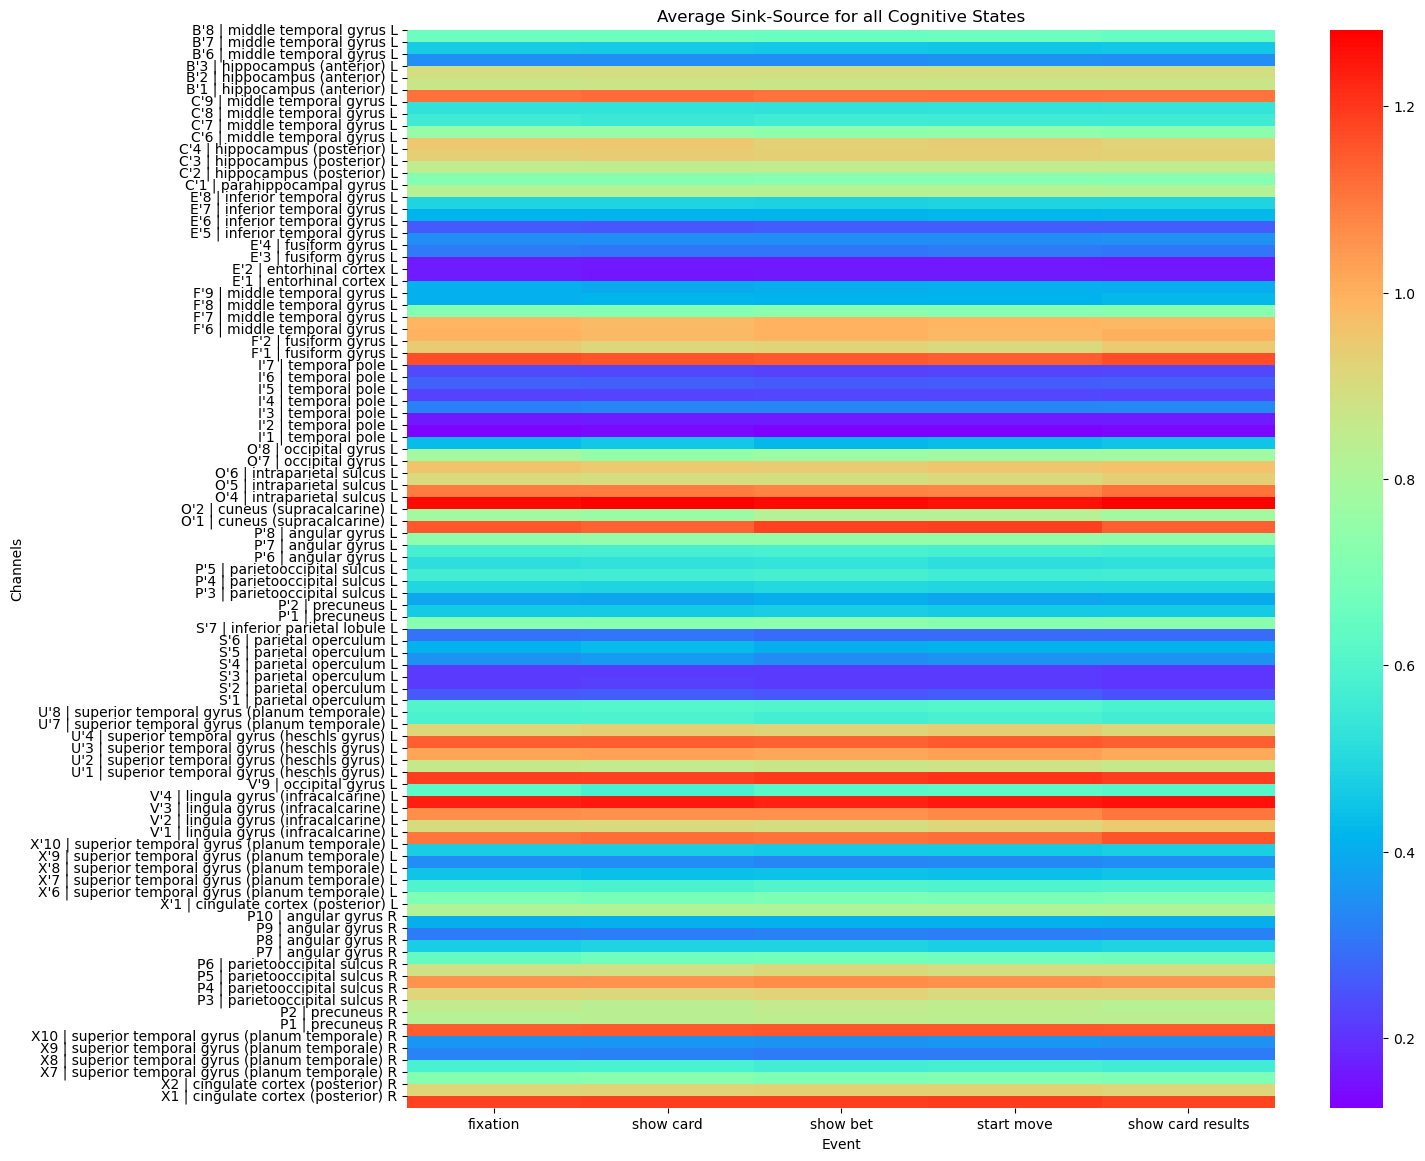

In [77]:
fig, axs = plt.subplots(figsize=(14, 14))
sns.heatmap(avg_SI_cog_state.mean(-1).T, cmap=sns.color_palette("rainbow", as_cmap=True), ax=axs)
axs.set_xticklabels(list(event_words.keys()))
axs.set_yticks(np.arange(avg_SI_cog_state.shape[1]))
axs.set_yticklabels(y_tick_labels, rotation=0)
axs.set_xlabel('Event')
axs.set_ylabel('Channels')
axs.set_title('Average Sink-Source for all Cognitive States')